In [244]:
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (8, 4)
sb.set(font_scale=1.)

In [245]:
DATA_FILE = "data\main-table.csv"

COLS = {
    'Region', 'Year', 'TotalTourists', 'ForeignTourists', 'HousesWithInternet%',
    'CompaniesWithWebSites%', 'AmountOfPeopleWithHighEducation',
    'PeopleWithHighEducationWithoutJob', 'AmountOfPeopleWithSecondaryEducation',
    'PeopleWithSecondaryEducationWithoutJob', 'AmountOfPeopleWithoutEducation',
    'PeopleWithoutEducationWithoutJob', 'AmountOfMales',
    'AmountOfMalesWithoutJob', 'AmountOfFemales',
    'AmountOfFemalesWithoutJob', 'AmountOfPeopleInRegion',
    'AmountOfPeopleInRegionWithoutJob', 'AmountOf_15-24_PeopleInRegion',
    'AmountOf_15-24_PeopleInRegionWithoutJob', 'AmountOf_15-64_PeopleInRegion',
    'AmountOf_15-64_PeopleInRegionWithoutJob', 'AmountOf_25-34_PeopleInRegion',
    'AmountOf_25-34_PeopleInRegionWithoutJob', 'AmountOf_35-44_PeopleInRegion',
    'AmountOf_35-44_PeopleInRegionWithoutJob', 'AmountOf_45-54_PeopleInRegion',
    'AmountOf_45-54_PeopleInRegionWithoutJob', 'AmountOf_55-64_PeopleInRegion',
    'AmountOf_55-64_PeopleInRegionWithoutJob', 'AmountOf_65+_PeopleInRegion'
}

DEPENDENT_COL = 'TotalTourists'

INDEX_COLS = {'Region', 'Year'}

REGIONS = { 
    "РЕПУБЛИКА СРБИЈА",
    "Београдски регион", 
    "Регион Војводине", 
    "Регион Шумадије и Западне Србије", 
    "Регион Јужне и Источне Србије" 
}

In [246]:
df = pd.read_csv(DATA_FILE, index_col=tuple(INDEX_COLS)).dropna()

region_dfs = df[df.index.get_level_values("Region") != "РЕПУБЛИКА СРБИЈА"].groupby("Region")
serbia_df = df[df.index.get_level_values("Region") == "РЕПУБЛИКА СРБИЈА"]

# NOTE: here we could do extrapolation, for now we dropped all na

serbia_df.head(11)

TotalTourists  ForeignTourists  HousesWithInternet%  \
Region           Year                                                        
РЕПУБЛИКА СРБИЈА 2014        2192268          1028732                 55.1   
                 2015        2437165          1132221                 56.0   
                 2016        2753591          1281426                 57.8   
                 2017        3085866          1497173                 61.9   
                 2018        3430522          1710514                 72.5   
                 2019        3689983          1846551                 79.6   
                 2020        1820021           445711                 80.8   

                       CompaniesWithWebSites%  \
Region           Year                           
РЕПУБЛИКА СРБИЈА 2014                    74.0   
                 2015                    75.2   
                 2016                    80.8   
                 2017                    80.4   
                 2018                    82.6   
                 2019                    83.6   
                 2020                    84.4   

                       AmountOfPeopleWithHighEducation  \
Region           Year                                    
РЕПУБЛИКА СРБИЈА 2014                        1039600.0   
                 2015                        1087700.0   
                 2016                        1114000.0   
                 2017                        1122700.0   
                 2018                        1149800.0   
                 2019                        1162600.0   
                 2020                        1174700.0   

                       PeopleWithHighEducationWithoutJob  \
Region           Year                                      
РЕПУБЛИКА СРБИЈА 2014                           110300.0   
                 2015                           116000.0   
                 2016                           108700.0   
                 2017                            98900.0   
                 2018                            90200.0   
                 2019                            69600.0   
                 2020                            65600.0   

                       AmountOfPeopleWithSecondaryEducation  \
Region           Year                                         
РЕПУБЛИКА СРБИЈА 2014                             3141700.0   
                 2015                             3120600.0   
                 2016                             3099200.0   
                 2017                             3086700.0   
                 2018                             3074900.0   
                 2019                             3078600.0   
                 2020                             3095500.0   

                       PeopleWithSecondaryEducationWithoutJob  \
Region           Year                                           
РЕПУБЛИКА СРБИЈА 2014                                397200.0   
                 2015                                355900.0   
                 2016                                309500.0   
                 2017                                274300.0   
                 2018                                256300.0   
                 2019                                208200.0   
                 2020                                177500.0   

                       AmountOfPeopleWithoutEducation  \
Region           Year                                   
РЕПУБЛИКА СРБИЈА 2014                       1917900.0   
                 2015                       1851600.0   
                 2016                       1804400.0   
                 2017                       1775300.0   
                 2018                       1730400.0   
                 2019                       1682700.0   
                 2020                       1624000.0   

                       PeopleWithoutEducationWithoutJob  ...  \
Region           Year                                    ...   
РЕПУБЛИКА СРБИЈА 2

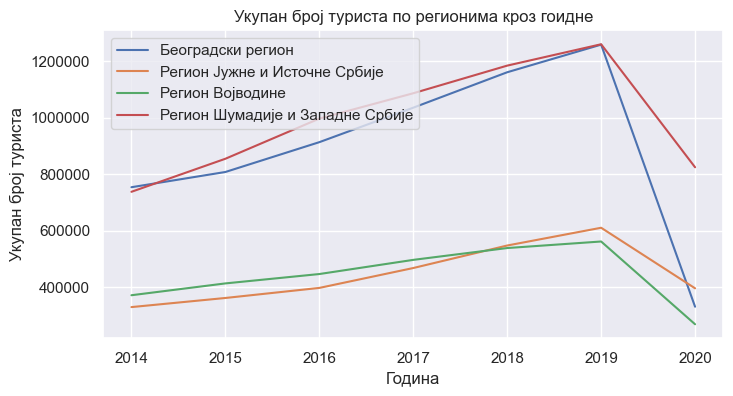

In [247]:
for region, region_df in region_dfs:
    plt.plot(region_df.index.get_level_values("Year"), region_df["TotalTourists"], label=region)

plt.xlabel("Година")
plt.ylabel("Укупан број туриста")
plt.title("Укупан број туриста по регионима кроз гоидне")
plt.ticklabel_format(style='plain')
plt.legend(loc='upper left')
plt.show()

In [248]:
def get_fitted_model(x, y):
    x_with_const = sm.add_constant(x)
    model = sm.OLS(y, x_with_const).fit()
    return model

In [249]:
# model
REGION = "Београдски регион"
region_df = region_dfs.get_group(REGION)
x = region_df[COLS - INDEX_COLS - {DEPENDENT_COL}]
y = region_df[DEPENDENT_COL]

model = get_fitted_model(x, y)
model.summary()

C:\Users\Aki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\stats\stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\Users\Aki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\Aki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\statsmodels\regression\linear_model.py:1766: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\Users\Aki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TotalTourists   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                nan
Time:                        18:30:30   Log-Likelihood:                 121.16
No. Observations:                   7   AIC:                            -228.3
Df Residuals:                       0   BIC:                            -228.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                    7.033e-08        inf          0        nan         nan         nan
AmountOf_55-64_PeopleInRegionWithoutJob    -0.0792        inf         -0        nan         nan         nan
CompaniesWithWebSites%                     -0.0008        inf         -0        nan         nan         nan
ForeignTourists                             1.1332        inf          0        nan         nan         nan
AmountOfPeopleInRegionWithoutJob            0.0830        inf          0        nan         nan         nan
AmountOfFemalesWithoutJob                  -0.0875        inf         -0        nan         nan         nan
AmountOf_65+_PeopleInRegion                 0.3230        inf          0        nan         nan         nan
AmountOf_35-44_PeopleInRegionWithoutJob     0.1628        inf          0        nan         nan         nan
AmountOf_45-54_PeopleInRegion               0.0748        inf          0        nan         nan         nan
AmountOf_15-64_PeopleInRegion              -0.1868        inf         -0        nan         nan         nan
AmountOf_15-24_PeopleInRegion              -0.0106        inf         -0        nan         nan         nan
AmountOf_25-34_PeopleInRegionWithoutJob    -0.3555        inf         -0        nan         nan         nan
PeopleWithoutEducationWithoutJob            0.3772        inf          0        nan         nan         nan
PeopleWithHighEducationWithoutJob          -0.4264        inf         -0        nan         nan         nan
AmountOf_55-64_PeopleInRegion              -0.2719        inf         -0        nan         nan         nan
AmountOfPeopleInRegion                      0.1359        inf          0        nan         nan         nan
AmountOf_35-44_PeopleInRegion               0.1392        inf          0        nan         nan         nan
AmountOfMales                               0.0593        inf          0        nan         nan         nan
HousesWithInternet%                        -0.0002        inf         -0        nan         nan         nan
AmountOfMalesWithoutJob                     0.1735        inf          0        nan         nan         nan
AmountOf_15-64_PeopleInRegionWithoutJob    -0.0392        inf         -0        nan         nan         nan
AmountOfPeopleWithoutEducation              0.5863        inf          0        nan         nan         nan
AmountOf_45-54_PeopleInRegionWithoutJob     0.0666        inf          0        nan         nan         nan
AmountOfPeopleWithHighEducation            -0.4336        inf         -0        nan         nan         nan
AmountOfPeopleWithSecondaryEducation       -0.0327        inf         -0        nan         nan         nan
AmountOfFemales                             0.0766        i

In [250]:
# correlation_matrix = region_df.corr()

# sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.1)
# plt.title("Матрица корелације")
# plt.show()

In [251]:
alpha = 5e-2

if model.f_pvalue <= alpha:
    print('bar jedna promenljiva X ima linearnu zavisnost sa promenljivom Y')
else:
    print('moguce je da ni jedna promenljiva nema znacajnu linearnu zavisnost sa Y')

model.rsquared # ??

moguce je da ni jedna promenljiva nema znacajnu linearnu zavisnost sa Y


1.0